In [9]:
%pip install neo4j python-dotenv matplotlib seaborn pandas numpy plotly wordcloud
from neo4j import GraphDatabase
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import wordcloud
sns.set_theme()

Defaulting to user installation because normal site-packages is not writeable
  Using cached neo4j-5.27.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp312-cp312-win_amd64.whl.metadata (168 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.0.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using ca

In [10]:
# Load environment variables from the .env file
load_dotenv()

# Get credentials from environment variables
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USERNAME")
password = os.getenv("NEO4J_PASSWORD")

In [11]:
driver = GraphDatabase.driver(uri, auth=(username, password))

In [12]:
def run_query(query, parameters=None):
    with driver.session() as session:
        result = session.run(query, parameters)
        return result.data()

In [13]:
example_query = "MATCH (n) RETURN n LIMIT 5"
run_query(example_query)

[{'n': {'CookTime': Duration(months=0, days=0, seconds=3600, nanoseconds=0),
   'PrepTime': Duration(months=0, days=0, seconds=1200, nanoseconds=0),
   'RecipeServings': 8,
   'TotalTime': Duration(months=0, days=0, seconds=4800, nanoseconds=0),
   'CarbohydrateContent': 39.3,
   'id': '373686',
   'FatContent': 18.0,
   'ProteinContent': 11.0,
   'Calories': 341.5,
   'Name': 'Picnic Cowboy Caviar'}},
 {'n': {'CookTime': Duration(months=0, days=0, seconds=1500, nanoseconds=0),
   'PrepTime': Duration(months=0, days=0, seconds=900, nanoseconds=0),
   'RecipeServings': 4,
   'TotalTime': Duration(months=0, days=0, seconds=2400, nanoseconds=0),
   'CarbohydrateContent': 85.1,
   'id': '406657',
   'FatContent': 5.3,
   'ProteinContent': 12.2,
   'Calories': 421.0,
   'Name': 'Turkey Schnitzel With Tots &amp; Apple-Cranberry Sauce'}},
 {'n': {'PrepTime': Duration(months=0, days=0, seconds=180, nanoseconds=0),
   'RecipeServings': 1,
   'TotalTime': Duration(months=0, days=0, seconds=180, 

## Ingredient Frequency

In [14]:
ingredientFrequencyQuery = """
MATCH (i:Ingredient)-[:CONTAINS]-(r:Recipe)
RETURN i.name AS ingredient, count(r) AS frequency
ORDER BY frequency DESC
"""

ingredientFrequency = run_query(ingredientFrequencyQuery)

frequenciesDF = pd.DataFrame(ingredientFrequency)
frequenciesDF.head()

ingredient  frequency
0       salt       3493
1     butter       2234
2      sugar       1897
3      onion       1525
4       eggs       1475

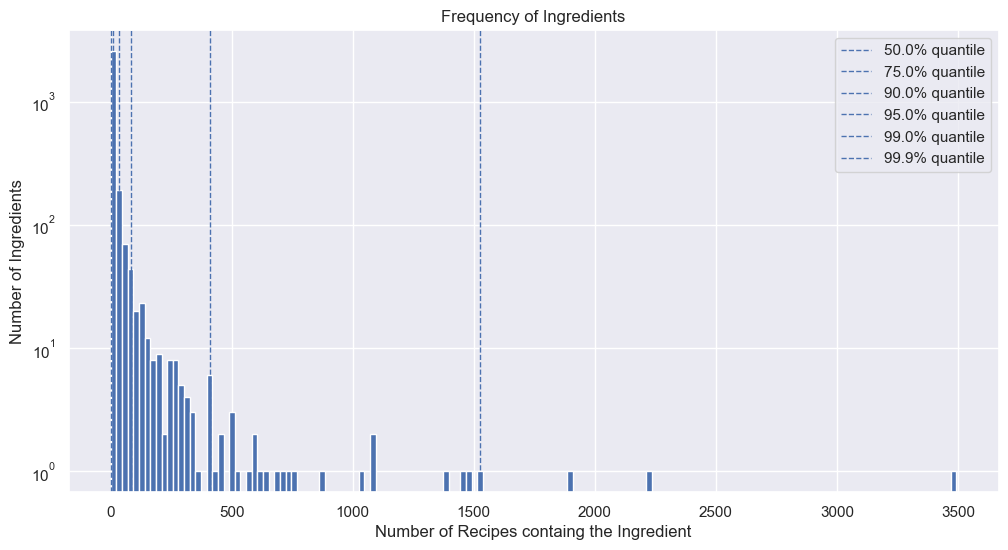

In [15]:
frequencies = frequenciesDF['frequency'].values
ingredients = frequenciesDF['ingredient'].values

# Create an Histogram of the ingredient frequency, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(frequencies, bins=150, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(frequencies, q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Recipes containg the Ingredient')
plt.ylabel('Number of Ingredients')
plt.title('Frequency of Ingredients')
plt.legend()
plt.show()

In [67]:
# Extract the top n ingredients
topN = 20
topIngredients = frequenciesDF.head(topN)
topIngredients

ingredient  frequency
0                salt       3493
1              butter       2234
2               sugar       1897
3               onion       1525
4                eggs       1475
5               water       1457
6           olive oil       1393
7               flour       1091
8       garlic cloves       1084
9                milk       1043
10             pepper        883
11        brown sugar        746
12  all-purpose flour        729
13      baking powder        707
14                egg        679
15             garlic        651
16        baking soda        621
17        lemon juice        593
18    parmesan cheese        583
19            vanilla        577

## Number of ingredients per recipe distribution

In [78]:
ingredientsPerRecipeQuery = """
MATCH (r:Recipe) -[:CONTAINS] - (i:Ingredient)
RETURN r.Name AS recipe, count(i) AS ingredients
ORDER BY ingredients DESC
"""

ingredientsPerRecipe = run_query(ingredientsPerRecipeQuery)
ingredientsPerRecipeDF = pd.DataFrame(ingredientsPerRecipe)
ingredientsPerRecipeDF.head()

recipe  ingredients
0      Zucchini Bread           60
1       Pumpkin Bread           47
2     Mexican Lasagna           43
3           Jambalaya           41
4  Chicken Enchiladas           40

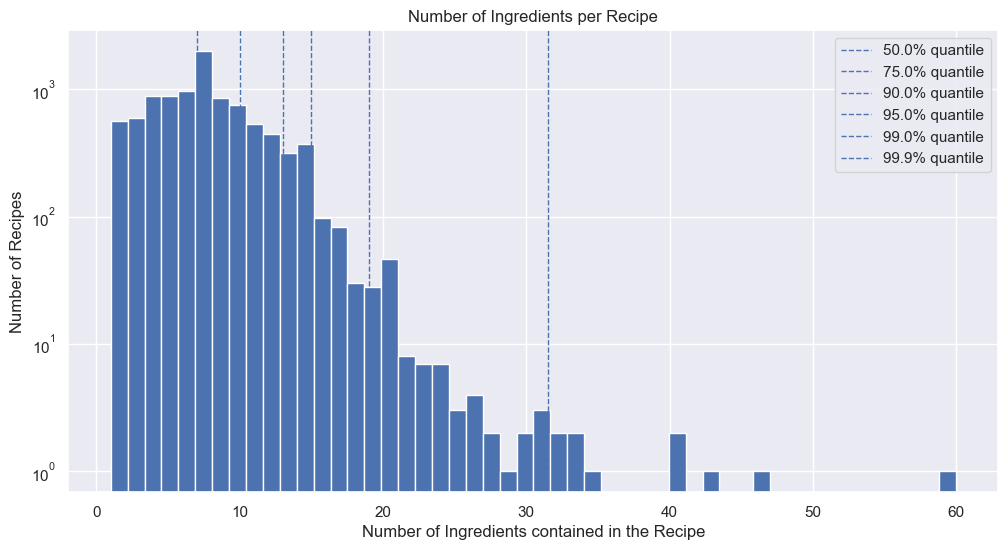

In [85]:
# Create a histogram of the number of ingredients per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(ingredientsPerRecipeDF['ingredients'], bins=50, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(ingredientsPerRecipeDF['ingredients'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Ingredients contained in the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Number of Ingredients per Recipe')
plt.legend()
plt.show()

## Review ratings distribution

In [89]:
reviewRatingsQuery = """
MATCH (r:Review)
RETURN r.rating AS rating, count(r) AS frequency
ORDER BY rating
"""

reviewRatings = run_query(reviewRatingsQuery)
reviewRatingsDF = pd.DataFrame(reviewRatings)
reviewRatingsDF.head()

rating  frequency
0       0       1347
1       1        295
2       2        301
3       3        948
4       4       4227

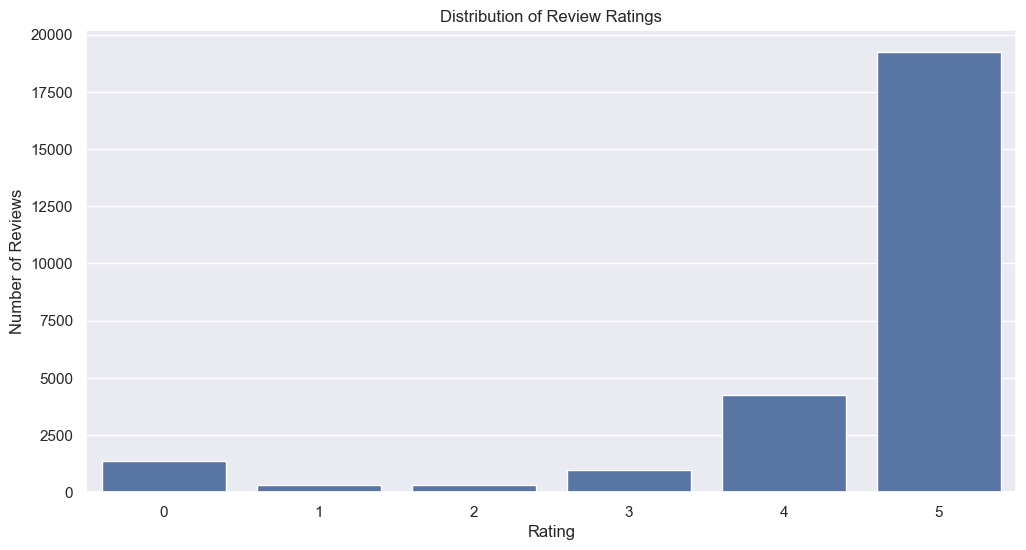

In [90]:
# Create a bar plot of the review ratings
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='frequency', data=reviewRatingsDF)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Ratings')
plt.show()

## Average rating per recipe distribution

In [91]:
avgRatingPerRecipeQuery = """
MATCH (r:Recipe) <-[:FOR] - (rev:Review)
RETURN r.Name AS recipe, avg(rev.rating) AS averageRating
ORDER BY averageRating DESC
"""

avgRatingPerRecipe = run_query(avgRatingPerRecipeQuery)
avgRatingPerRecipeDF = pd.DataFrame(avgRatingPerRecipe)
avgRatingPerRecipeDF.head()

recipe  averageRating
0                                   Banilla Splash            5.0
1                        Sausage and Green Pea Pie            5.0
2  Oil-Poached-Garlic Puree and Roasted-Garlic Oil            5.0
3                                 Potato Casserole            5.0
4                                 Aztec Gold Chili            5.0

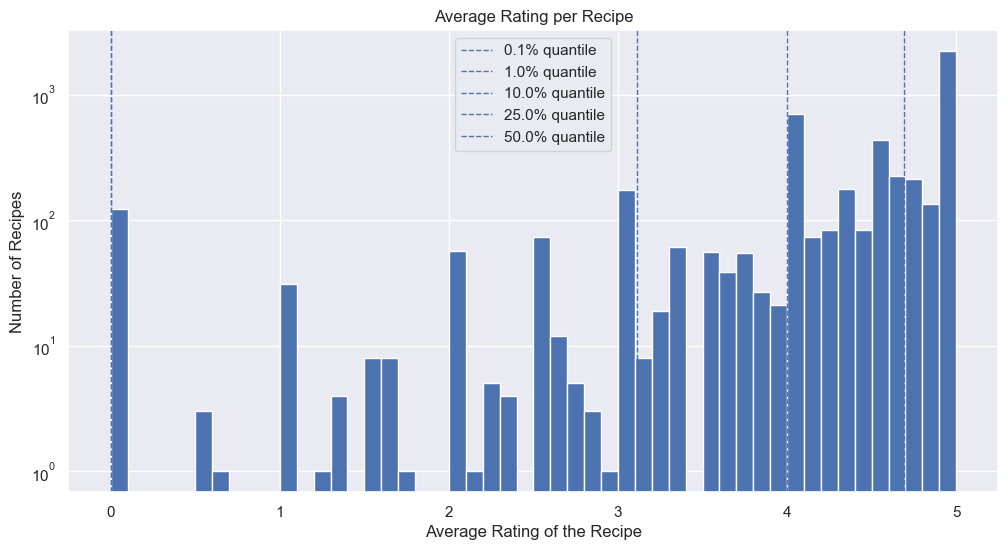

In [96]:
# Create a histogram of the average rating per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(avgRatingPerRecipeDF['averageRating'], bins=50, log=True)
quantiles = [0.001, 0.01, 0.1, 0.25, 0.5]
for q in quantiles:
    plt.axvline(np.quantile(avgRatingPerRecipeDF['averageRating'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Average Rating of the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Average Rating per Recipe')
plt.legend()
plt.show()

## Number of reviews per recipe distribution

In [98]:
numberOfReviewsPerRecipeQuery = """
MATCH (r:Recipe) <-[:FOR] - (rev:Review)
RETURN r.Name AS recipe, count(rev) AS numberOfReviews
ORDER BY numberOfReviews DESC
"""

numberOfReviewsPerRecipe = run_query(numberOfReviewsPerRecipeQuery)
numberOfReviewsPerRecipeDF = pd.DataFrame(numberOfReviewsPerRecipe)
numberOfReviewsPerRecipeDF.head()

recipe  numberOfReviews
0              Dark Chocolate Cake              520
1  Oven Fried Eggplant (Aubergine)              292
2  Oatmeal Cottage Cheese Pancakes              263
3   Old-Fashioned Banana Cream Pie              243
4  Kittencal's Famous Caesar Salad              214

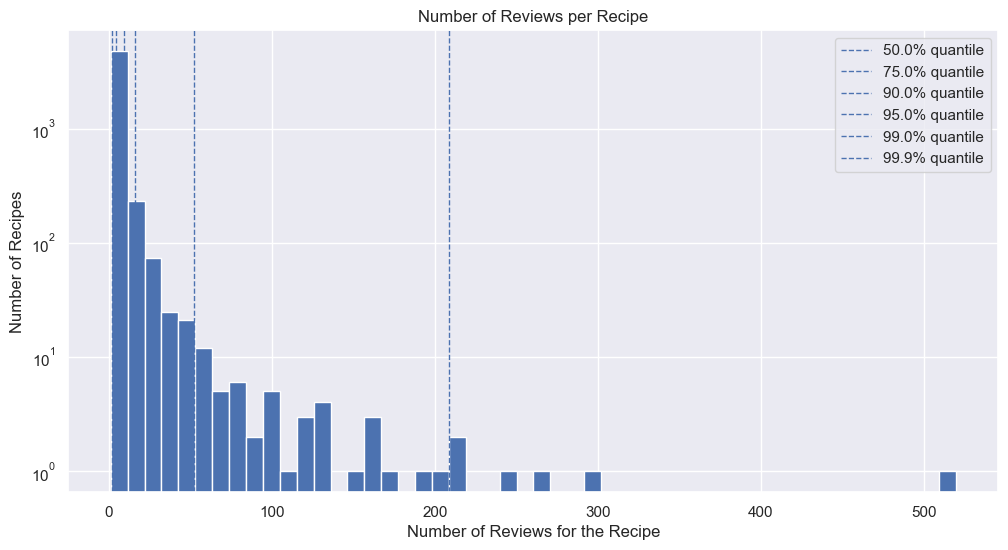

In [100]:
# Create a histogram of the number of reviews per recipe, the y-axis is log10 scaled, some vertical lines are added to show the 50%, 75% and 90%, 95% quantiles
plt.figure(figsize=(12, 6))
plt.hist(numberOfReviewsPerRecipeDF['numberOfReviews'], bins=50, log=True)
quantiles = [0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
for q in quantiles:
    plt.axvline(np.quantile(numberOfReviewsPerRecipeDF['numberOfReviews'], q), linestyle='dashed', linewidth=1, label=f'{q*100}% quantile')
plt.xlabel('Number of Reviews for the Recipe')
plt.ylabel('Number of Recipes')
plt.title('Number of Reviews per Recipe')
plt.legend()
plt.show()

# QUERY 3 - Fastest categories

In [136]:
totalTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.TotalTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.TotalTime.minutes)) AS avgTotalTimeMinutes
ORDER BY avgTotalTimeMinutes ASC
"""

totalTimePerRecipe = run_query(totalTimePerRecipeQuery)
totalTimePerRecipeDF = pd.DataFrame(totalTimePerRecipe)
totalTimePerRecipeDF.head()

category  avgTotalTimeMinutes
0      Oatmeal                    4
1     Szechuan                    5
2    Smoothies                    7
3    < 15 Mins                    9
4  Bath/Beauty                   10

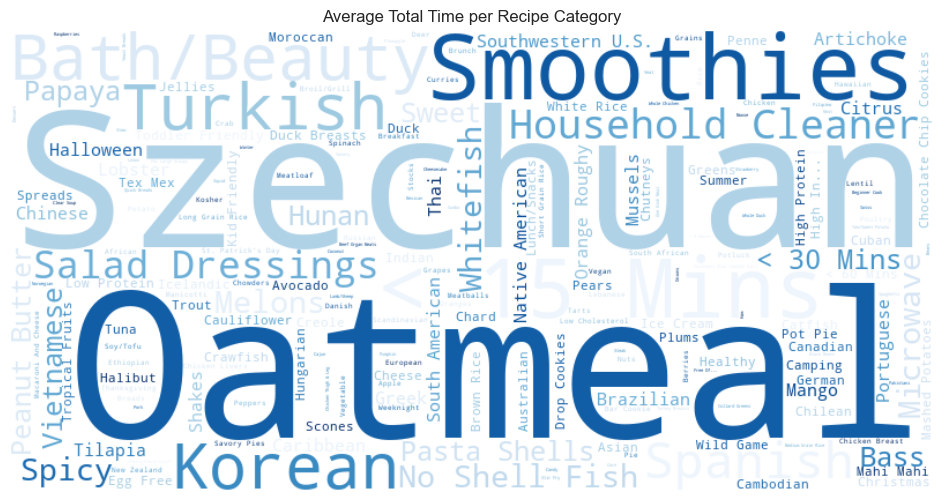

In [138]:
# 
invertedTotalTimePerRecipeDF = totalTimePerRecipeDF["avgTotalTimeMinutes"].max() - totalTimePerRecipeDF["avgTotalTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white', colormap='Blues').generate_from_frequencies(dict(zip(totalTimePerRecipeDF["category"], invertedTotalTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Total Time per Recipe Category')
plt.show()

## Fastest cook time per category

In [114]:
cookTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.CookTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.CookTime.minutes)) AS avgCookTimeMinutes
ORDER BY avgCookTimeMinutes ASC
"""

cookTimePerRecipe = run_query(cookTimePerRecipeQuery)
cookTimePerRecipeDF = pd.DataFrame(cookTimePerRecipe)
cookTimePerRecipeDF.head()

category  avgCookTimeMinutes
0              Oatmeal                   2
1               Shakes                   4
2  Homeopathy/Remedies                   5
3                 Easy                   5
4          Bath/Beauty                   6

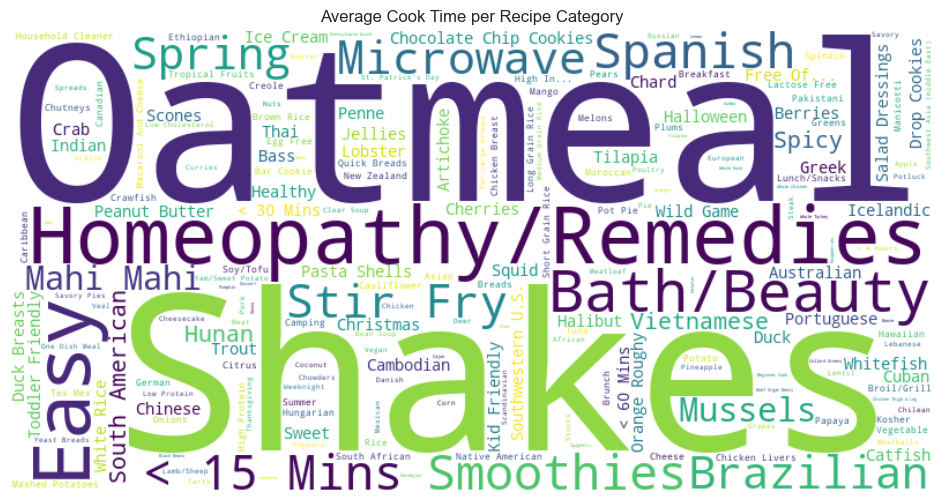

In [119]:
# Create a word cloud of the recipe categories
invertedCookTimePerRecipeDF = cookTimePerRecipeDF["avgCookTimeMinutes"].max() - cookTimePerRecipeDF["avgCookTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(cookTimePerRecipeDF["category"], invertedCookTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Cook Time per Recipe Category')
plt.show()

## Fastest prep time per category

In [116]:
prepTimePerRecipeQuery = """
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.PrepTime IS NOT NULL
RETURN c.name AS category, tointeger(AVG(r.PrepTime.minutes)) AS avgPrepTimeMinutes
ORDER BY avgPrepTimeMinutes ASC
"""

prepTimePerRecipe = run_query(prepTimePerRecipeQuery)
prepTimePerRecipeDF = pd.DataFrame(prepTimePerRecipe)
prepTimePerRecipeDF.head()

category  avgPrepTimeMinutes
0            Oatmeal                   2
1  Household Cleaner                   4
2          Whitefish                   5
3            Swedish                   5
4           Szechuan                   5

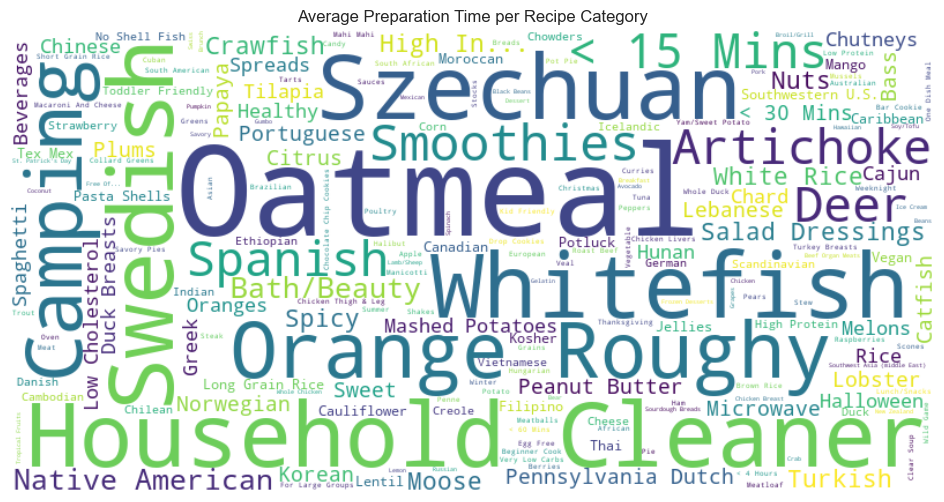

In [118]:
# Create a word cloud of the recipe categories
invertedPrepTimePerRecipeDF = prepTimePerRecipeDF["avgPrepTimeMinutes"].max() - prepTimePerRecipeDF["avgPrepTimeMinutes"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(prepTimePerRecipeDF["category"], invertedPrepTimePerRecipeDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Average Preparation Time per Recipe Category')
plt.show()

# QUERY 4 - Most useful ingredients

In [124]:
numberOfCategoriesPerIngredientQuery = """
MATCH (i:Ingredient)<-[:CONTAINS]-(r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
RETURN i.name AS ingredient, COUNT(DISTINCT c) AS NumOfCategories
ORDER BY NumOfCategories DESC
"""

numberOfCategoriesPerIngredient = run_query(numberOfCategoriesPerIngredientQuery)
numberOfCategoriesPerIngredientDF = pd.DataFrame(numberOfCategoriesPerIngredient)
numberOfCategoriesPerIngredientDF.head()

ingredient  NumOfCategories
0       salt              175
1     butter              142
2      water              139
3  olive oil              137
4      onion              136

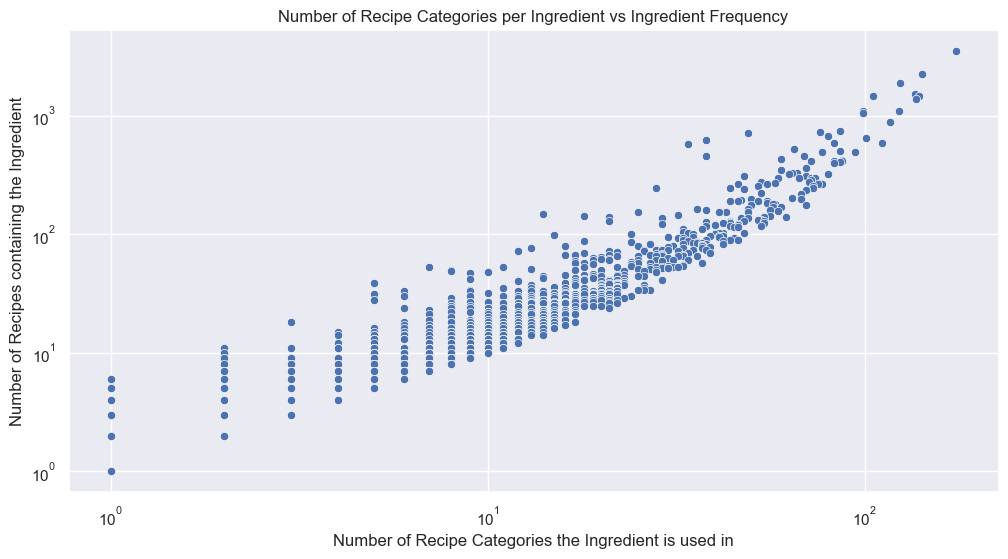

In [129]:
#scatter plot of the number of categories per ingredient vs the frequency of the ingredient
#join the two dataframes matching the ingredient name
joinedDF = pd.merge(frequenciesDF, numberOfCategoriesPerIngredientDF)

plt.figure(figsize=(12, 6))
sns.scatterplot(x='NumOfCategories', y='frequency', data=joinedDF)
plt.xlabel('Number of Recipe Categories the Ingredient is used in')
plt.ylabel('Number of Recipes containing the Ingredient')
plt.title('Number of Recipe Categories per Ingredient vs Ingredient Frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()


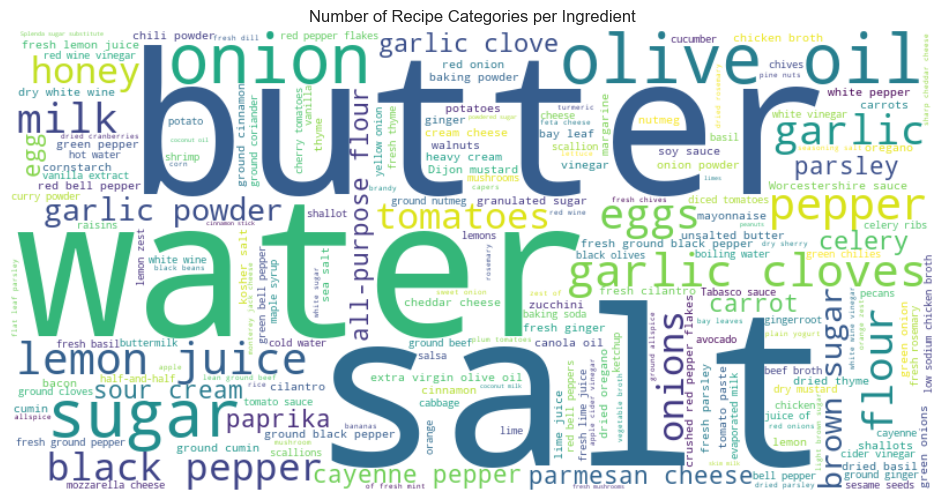

In [133]:
# Create a word cloud of the ingredients based on the number of categories they are used in
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(numberOfCategoriesPerIngredientDF["ingredient"], numberOfCategoriesPerIngredientDF["NumOfCategories"])))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Number of Recipe Categories per Ingredient')
plt.show()

In [13]:
query = """
MATCH (r:Recipe)-[:CONTAINS]->(i:Ingredient)
WHERE i.name IN $ingredients
WITH r, count(i) AS matchingScore, COLLECT(i.name) AS matchingIngredients
RETURN r, matchingScore, matchingIngredients ORDER BY matchingScore DESC
"""

parameters = {
    "ingredients": ["salt", "pepper", "garlic"]
}

result = run_query(query, parameters)
resultDF = pd.DataFrame(result)
resultDF.head()

r  matchingScore  \
0  {'CookTime': (0, 0, 3600, 0), 'PrepTime': (0, ...              3   
1  {'CookTime': (0, 0, 21600, 0), 'PrepTime': (0,...              3   
2  {'PrepTime': (0, 0, 600, 0), 'TotalTime': (0, ...              3   
3  {'CookTime': (0, 0, 3600, 0), 'PrepTime': (0, ...              3   
4  {'PrepTime': (0, 0, 0, 0), 'RecipeServings': 4...              3   

      matchingIngredients  
0  [salt, pepper, garlic]  
1  [salt, pepper, garlic]  
2  [salt, pepper, garlic]  
3  [salt, pepper, garlic]  
4  [salt, pepper, garlic]

# QUERIES NEO4J

## 1. Mix & Max

In [25]:
mixAndMaxQuery = """
WITH $providedIngredients AS ingredients
    MATCH 
    (i:Ingredient)<-[:CONTAINS]-(r:Recipe)-[:CONTAINS]->(i1:Ingredient)
    WHERE i.name IN ingredients AND NOT i1.name IN ingredients
    WITH DISTINCT r, i1.name AS matchedIngredient, ingredients, 
    COUNT(DISTINCT i) as availableMatchedIngredients
    MATCH (r)<-[:FOR]-(rev:Review)
    WITH matchedIngredient, r, AVG(rev.rating) AS avgRating, ingredients, 
    availableMatchedIngredients
    MATCH (r)-[:CONTAINS]->(i:Ingredient)
    WHERE i.name IN ingredients
    RETURN matchedIngredient, COUNT(DISTINCT r) AS recipeCount, 
    ROUND(AVG(avgRating),2) AS Rating, 
    ROUND(AVG(availableMatchedIngredients),2) AS Compatibility
    ORDER BY Compatibility * log10(recipeCount) DESC;
"""
parameters = {
    "providedIngredients": ["chicken", "curry", "salt"]
}

matchingIngredients = run_query(mixAndMaxQuery,parameters)
matchingIngredientsDF = pd.DataFrame(matchingIngredients)
matchingIngredientsDF.head()

matchedIngredient  recipeCount  Rating  Compatibility
0            butter          585    4.32           1.02
1             onion          368    4.36           1.07
2             sugar          514    4.39           1.01
3            pepper          393    4.33           1.05
4             water          350    4.32           1.05

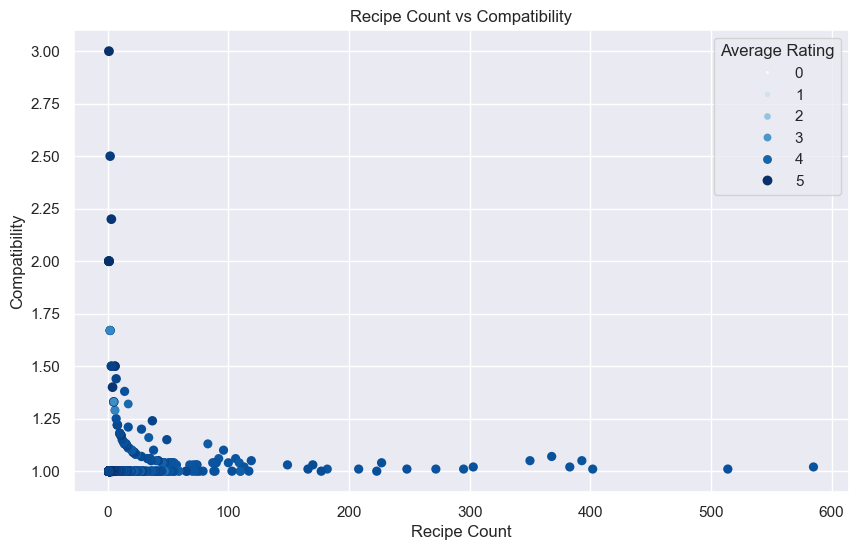

In [161]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=matchingIngredientsDF, x='recipeCount', y='Compatibility', hue='Rating', palette='Blues', size='Rating', sizes=(5, 50), edgecolor='none')
plt.title("Recipe Count vs Compatibility")
plt.xlabel("Recipe Count")
plt.ylabel("Compatibility")


plt.legend(title="Average Rating")
plt.show()

## 2. Recipe substitutes

In [48]:
substituterecipequery= """
MATCH (r1:Recipe {Name: $recipeName })-[:BELONGS_TO]->(c:RecipeCategory)
<-[:BELONGS_TO]-(r2:Recipe)
WHERE ABS(COALESCE(r1.Calories, 0) - COALESCE(r2.Calories, 0)) <= 100 
AND r1 <> r2 AND NOT EXISTS {
MATCH (r1)-[:CONTAINS]->(i:Ingredient)<-[:CONTAINS]-(r2) 
}
RETURN r2.Name AS SimilarRecipe,
round(ABS(COALESCE(r1.Calories, 0) - COALESCE(r2.Calories, 0)), 1) 
AS CalorieDifference
ORDER BY CalorieDifference ASC; 
"""
parameters = {
    "recipeName": "Mexican Lasagna"
}

substituteRecipe = run_query(substituterecipequery,parameters)
substituteRecipeDF = pd.DataFrame(substituteRecipe)
substituteRecipeDF.head()

SimilarRecipe  CalorieDifference
0                        Big John's Stampede Chicken                0.1
1                                Leek and Potato Pie                0.7
2  Tortellini With Roasted Eggplant &amp; Peppers...                0.8
3                           Birthday Caramel Chicken                1.0
4                          Chicken and Vegi Stir Fry                1.3

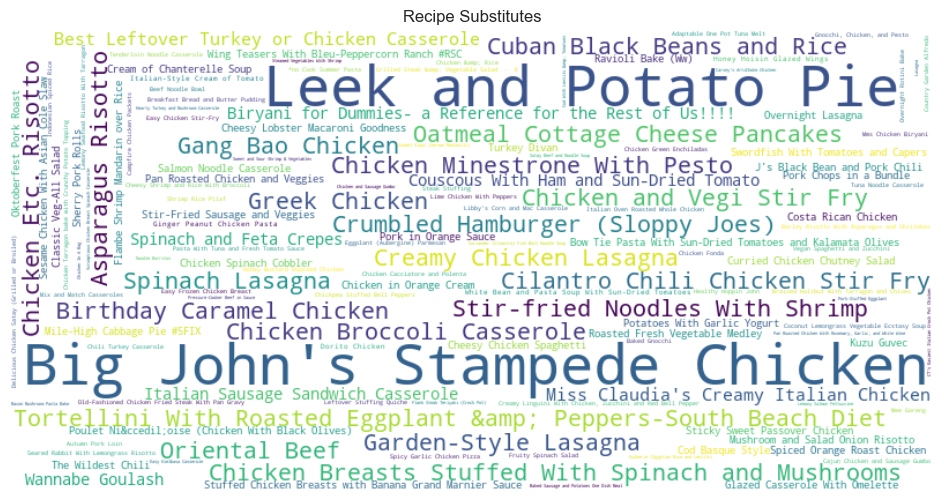

In [64]:
invertedCalorieDifferenceDF = substituteRecipeDF["CalorieDifference"].max() - substituteRecipeDF["CalorieDifference"]
wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(substituteRecipeDF["SimilarRecipe"], invertedCalorieDifferenceDF)))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Recipe Substitutes')
plt.show()


## 3. Large groups meals

In [66]:
largeGroupsQuery= """
MATCH 
(c:RecipeCategory)<-[:BELONGS_TO]-(r:Recipe)-[:CONTAINS]->(i:Ingredient),
(r)-[:DESCRIBED_BY]->(k:Keyword)
WHERE tointeger(r.RecipeServings) >= 10 
OR c.name = 'For Large Groups' 
OR k.name = 'For Large Groups'
WITH r, COLLECT(DISTINCT i.name) AS Ingredients,
COUNT(DISTINCT i) AS RequiredIngredients
RETURN r.Name AS RecipeName,
RequiredIngredients, Ingredients
ORDER BY RequiredIngredients ASC;
"""

largeGroups = run_query(largeGroupsQuery)
largeGroupsDF = pd.DataFrame(largeGroups)
largeGroupsDF.head()

RecipeName  RequiredIngredients  \
0                              Homemade Martinelli's                    1   
1  Lip-Smackin, Party-Snackin Mini Piggies in a B...                    1   
2                               Presto Pesto Rollups                    1   
3                                      Cocktail Dogs                    1   
4          Minty (Or Other Flavor) Chocolate Cookies                    1   

              Ingredients  
0            [ginger ale]  
1  [sharp cheddar cheese]  
2           [pesto sauce]  
3      [prepared mustard]  
4  [white chocolate bark]

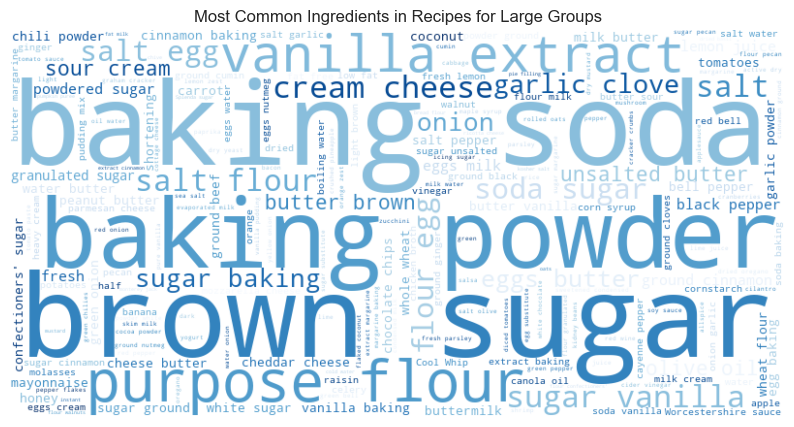

In [82]:
ingredient_text = ' '.join([', '.join(ingredients) for ingredients in largeGroupsDF['Ingredients']])

wordcloud = wordcloud.WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(ingredient_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Ingredients in Recipes for Large Groups")
plt.show()

## 4. Recipe Suggestions for users

In [85]:
recipeSuggestionQuery = """
MATCH (u:User)-[:WROTE]->(review:Review)-[:FOR]->(r:Recipe)
-[:CONTAINS]->(i:Ingredient)
WHERE review.rating > 4 AND u.name= $userName
MATCH (suggested:Recipe)-[:CONTAINS]->(i)
WHERE NOT (u)-[:WROTE]->()-[:FOR]->(suggested)
WITH suggested, COUNT(DISTINCT i) AS matchingIngredients
RETURN suggested.Name AS recipeName, matchingIngredients
ORDER BY matchingIngredients DESC;
"""
parameters = {
    "userName" : "Conan Lloyd"
}

recipeSuggestion = run_query(recipeSuggestionQuery,parameters)
recipeSuggestionDF = pd.DataFrame(recipeSuggestion)
recipeSuggestionDF.head()

recipeName  matchingIngredients
0    Crispy Chicken Tenders With Honey Mustard Sauce                    5
1  Neely's Crispy Panko Chicken Tenders and Honey...                    5
2                                    Chicken Marsala                    5
3                     Chicken With Cordon Bleu Gravy                    4
4                      Glazed Barbecued Ribs - Baked                    4

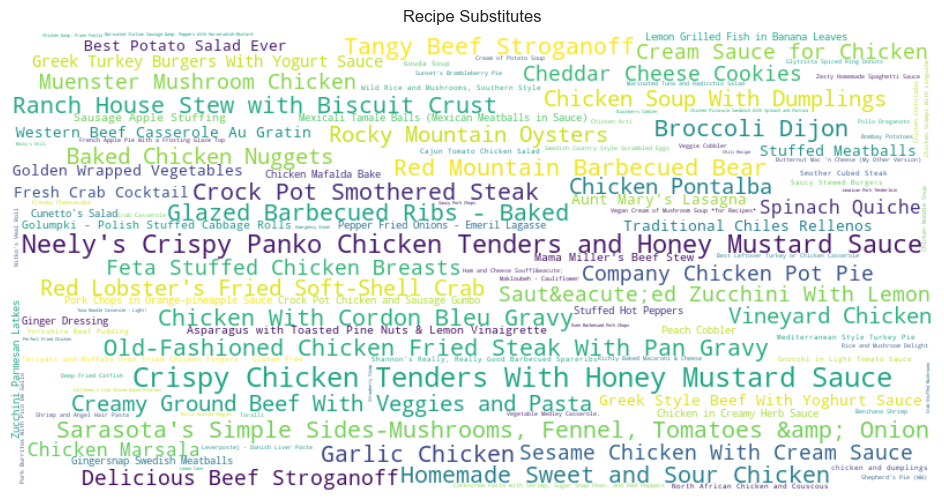

In [105]:
import wordcloud

wordCloud = wordcloud.WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(recipeSuggestionDF["recipeName"], recipeSuggestionDF["matchingIngredients"])))
plt.figure(figsize=(12, 6))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Recipe Substitutes')
plt.show()

## 5. Most diversified ingredients

In [107]:
diversifiedIngredientQuery= """
MATCH 
(i:Ingredient)<-[:CONTAINS]-(r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
OPTIONAL MATCH  (r)<-[:FOR]-(rev:Review)
WITH i.name AS IngredientName, c.name AS CategoryName, 
AVG(rev.rating) AS AvgRatingPerCategory
WITH IngredientName, 
COUNT(DISTINCT CategoryName) AS NumOfCategories, 
AVG(AvgRatingPerCategory) AS AvgRatingAcrossCategories
RETURN IngredientName, NumOfCategories, 
round(AvgRatingAcrossCategories, 2) AS AvgRatingAcrossCategories
ORDER BY NumOfCategories DESC, 
AvgRatingAcrossCategories DESC;
"""
diversifiedIngredient = run_query(diversifiedIngredientQuery)
diversifiedIngredientDF = pd.DataFrame(diversifiedIngredient)
diversifiedIngredientDF.head()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH \n(i:Ingredient)<-[:CONTAINS]-(r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)\nOPTIONAL MATCH  (r)<-[:FOR]-(rev:Review)\nWITH i.name AS IngredientName, c.name AS CategoryName, \nAVG(rev.rating) AS AvgRatingPerCategory\nWITH IngredientName, \nCOUNT(DISTINCT CategoryName) AS NumOfCategories, \nAVG(AvgRatingPerCategory) AS AvgRatingAcrossCategories\nRETURN IngredientName, NumOfCategories, \nround(AvgRatingAcrossCategories, 2) AS AvgRatingAcrossCategories\nORDER BY NumOfCategories DESC, \nAvgRatingAcrossCategories DESC;\n'


IngredientName  NumOfCategories  AvgRatingAcrossCategories
0           salt              175                       4.37
1         butter              142                       4.32
2          water              139                       4.40
3      olive oil              137                       4.33
4          onion              136                       4.45

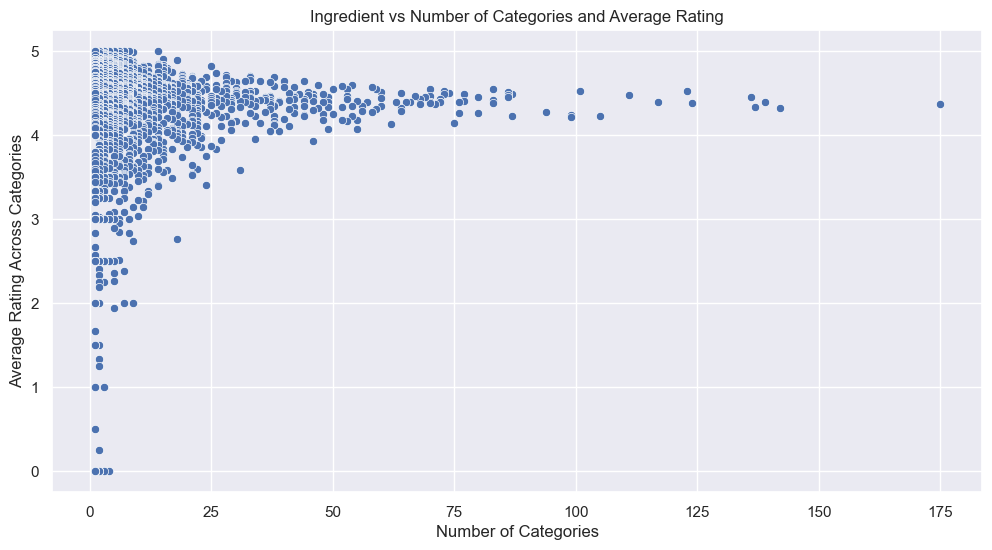

In [157]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=diversifiedIngredientDF, x='NumOfCategories', y='AvgRatingAcrossCategories',  legend=False)
plt.title("Ingredient vs Number of Categories and Average Rating")
plt.xlabel("Number of Categories")
plt.ylabel("Average Rating Across Categories")
plt.show()


## 6. Find Similar Recipes Based on Shared Ingredients, Keywords, and Categories

In [118]:
similarRecipesQuery = """
MATCH 
(r1:Recipe {Name: $recipeName})-[:CONTAINS]->
(i:Ingredient)<-[:CONTAINS]-(r2:Recipe),
(r1)-[:BELONGS_TO]->(c1:RecipeCategory),
(r2)-[:BELONGS_TO]->(c2:RecipeCategory)
OPTIONAL MATCH 
(r1)-[:DESCRIBED_BY]->(k:Keyword)<-[:DESCRIBED_BY]-(r2)
WHERE r1 <> r2
RETURN r2.Name AS SimilarRecipe, 
COUNT(DISTINCT i) AS SharedIngredients, 
COUNT(DISTINCT k) AS SharedKeywords, 
COLLECT(DISTINCT i.name) AS SharedIngredientsList, 
COLLECT(DISTINCT k.name) AS SharedKeywordsList, 
CASE WHEN c1.name = c2.name THEN "Yes" ELSE "No" END AS SameCategory
ORDER BY SharedIngredients DESC, SharedKeywords DESC;
"""

parameters = {
    "recipeName": "Sesame Chicken With Cream Sauce"
}

similarRecipe = run_query(similarRecipesQuery,parameters)
similarRecipeDF = pd.DataFrame(similarRecipe)
similarRecipeDF.head()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.AggregationSkippedNull} {category: UNRECOGNIZED} {title: The query contains an aggregation function that skips null values.} {description: null value eliminated in set function.} {position: None} for query: '\nMATCH \n(r1:Recipe {Name: $recipeName})-[:CONTAINS]->\n(i:Ingredient)<-[:CONTAINS]-(r2:Recipe),\n(r1)-[:BELONGS_TO]->(c1:RecipeCategory),\n(r2)-[:BELONGS_TO]->(c2:RecipeCategory)\nOPTIONAL MATCH \n(r1)-[:DESCRIBED_BY]->(k:Keyword)<-[:DESCRIBED_BY]-(r2)\nWHERE r1 <> r2\nRETURN r2.Name AS SimilarRecipe, \nCOUNT(DISTINCT i) AS SharedIngredients, \nCOUNT(DISTINCT k) AS SharedKeywords, \nCOLLECT(DISTINCT i.name) AS SharedIngredientsList, \nCOLLECT(DISTINCT k.name) AS SharedKeywordsList, \nCASE WHEN c1.name = c2.name THEN "Yes" ELSE "No" END AS SameCategory\nORDER BY SharedIngredients DESC, SharedKeywords DESC;\n'


SimilarRecipe  SharedIngredients  SharedKeywords  \
0               Toyko Chicken                  4               4   
1  Crock Pot Amaretto Chicken                  4               3   
2    Margo's Chicken Marinade                  4               2   
3    Chicken Cabbage Stir Fry                  4               1   
4              Golden Tilapia                  4               1   

                               SharedIngredientsList  \
0  [lemon juice, dry mustard, soy sauce, sesame s...   
1  [garlic powder, mushrooms, lemon juice, bonele...   
2  [lemon juice, soy sauce, boneless skinless chi...   
3  [garlic powder, water, soy sauce, boneless ski...   
4     [garlic powder, water, lemon juice, soy sauce]   

                  SharedKeywordsList SameCategory  
0  [Meat, Poultry, < 30 Mins, Asian]           No  
1           [Meat, Poultry, Chicken]          Yes  
2                    [Meat, Poultry]           No  
3                        [< 30 Mins]           No  
4                        [< 30 Mins]           No

## 7. Analyze Recipe Categories by Average Cooking Time and Ingredient Count

In [133]:
recipeCategoriesQuery="""
MATCH (r:Recipe)-[:BELONGS_TO]->(c:RecipeCategory)
WHERE r.TotalTime IS NOT NULL
MATCH (r)-[:CONTAINS]->(i:Ingredient)
WITH c, r, r.TotalTime.minutes AS totalTimeMinutes,
COUNT(DISTINCT i) AS numIngredients
WITH c, AVG(totalTimeMinutes) AS avgTotalTimeMinutes,
MIN(totalTimeMinutes) AS minTotalTimeMinutes,
MAX(totalTimeMinutes) AS maxTotalTimeMinutes,
AVG(numIngredients) AS avgIngredientsPerCategory
RETURN c.name AS category,
tointeger(avgTotalTimeMinutes) AS avgTotalTimeMinutes,
tointeger(minTotalTimeMinutes) AS minTotalTimeMinutes,
tointeger(maxTotalTimeMinutes) AS maxTotalTimeMinutes,
tointeger(avgIngredientsPerCategory) AS avgIngredientsPerCategory
ORDER BY avgTotalTimeMinutes ASC;
"""

recipeCategories = run_query(recipeCategoriesQuery)
recipeCategoriesDF = pd.DataFrame(recipeCategories)
recipeCategoriesDF.head()

category  avgTotalTimeMinutes  minTotalTimeMinutes  maxTotalTimeMinutes  \
0      Oatmeal                    4                    4                    4   
1     Szechuan                    5                    5                    5   
2    Smoothies                    7                    2                   70   
3    < 15 Mins                    9                    0                   15   
4  Bath/Beauty                   10                    3                   20   

   avgIngredientsPerCategory  
0                          5  
1                          5  
2                          3  
3                          5  
4                          2

## 8. Rank Ingredients by Average Recipe Ratings and Popularity

In [140]:
ingredientrankQuery = """
MATCH (i:Ingredient)<-[:CONTAINS]-(r:Recipe)<-[:FOR]-(review:Review)
WITH i.name AS Ingredient,
review.rating AS Rating,review
RETURN Ingredient, round(Avg(Rating), 2) AS AvgRating,
COUNT(review) AS ReviewCount
ORDER BY AvgRating * log10(ReviewCount) DESC;
"""
ingredientrank = run_query(ingredientrankQuery)
ingredientrankDF = pd.DataFrame(ingredientrank)
ingredientrankDF.head()

Ingredient  AvgRating  ReviewCount
0       salt       4.41        10236
1     butter       4.42         6492
2      sugar       4.41         6241
3      onion       4.44         4226
4      flour       4.42         4153